In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from script.data_loading import find_path, make_path, study_info
from script.junctions import get_junctions
from script.sequences import Annotator
from script.predictions import SpliceSitePredictor, spliceai, pangolin

from definitions import brca1

In [2]:
study_info.head()

,splice,expression,wgs_brass,wgs_pindel,wgs_caveman,total_size
case_id,,,,,,
c1442467-d618-435f-8792-b1a18f696f1a,65c868ba-94ed-43f2-bfd1-814979ee9486.rna_seq.s...,65c868ba-94ed-43f2-bfd1-814979ee9486.rna_seq.a...,c2603e63-fa7d-4ebc-936e-bed52cc932e4.wgs.BRASS...,c2603e63-fa7d-4ebc-936e-bed52cc932e4.wgs.sange...,c2603e63-fa7d-4ebc-936e-bed52cc932e4.wgs.CaVEM...,95698959
9435447e-d65f-408b-863b-6576b1d652dd,7c9a2493-5667-48ec-8998-81e13722b4ab.rna_seq.s...,7c9a2493-5667-48ec-8998-81e13722b4ab.rna_seq.a...,fb4526f0-ee99-46aa-a0df-f125a460b0a3.wgs.BRASS...,fb4526f0-ee99-46aa-a0df-f125a460b0a3.wgs.sange...,fb4526f0-ee99-46aa-a0df-f125a460b0a3.wgs.CaVEM...,87714708
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3,1a3dcc95-64bf-4886-9807-9511b24f30af.rna_seq.s...,1a3dcc95-64bf-4886-9807-9511b24f30af.rna_seq.a...,a30866df-bce8-46ff-8918-bfa7956fdfbc.wgs.BRASS...,a30866df-bce8-46ff-8918-bfa7956fdfbc.wgs.sange...,a30866df-bce8-46ff-8918-bfa7956fdfbc.wgs.CaVEM...,96440606
0adf59c6-581a-475d-a2f4-40aa40060b5b,9d025af7-ba40-4329-9308-d039aaad900b.rna_seq.s...,9d025af7-ba40-4329-9308-d039aaad900b.rna_seq.a...,aa368df9-0840-4619-86d3-46bf56179fee.wgs.BRASS...,aa368df9-0840-4619-86d3-46bf56179fee.wgs.sange...,aa368df9-0840-4619-86d3-46bf56179fee.wgs.CaVEM...,95034341
0045349c-69d9-4306-a403-c9c1fa836644,36125e17-48fd-4eea-874c-ed2e2e218402.rna_seq.s...,36125e17-48fd-4eea-874c-ed2e2e218402.rna_seq.a...,4598a0fe-4bbf-413d-8f9b-db38d4f213d5.wgs.BRASS...,4598a0fe-4bbf-413d-8f9b-db38d4f213d5.wgs.sange...,4598a0fe-4bbf-413d-8f9b-db38d4f213d5.wgs.CaVEM...,90039272


## Find and aggregate absolute junction use

In [3]:
junctions_path = 'junctions.pkl'
try:
    junctions = pd.read_pickle(find_path(junctions_path))
except KeyError:
    junctions = pd.DataFrame()
    for case_id in study_info.index:
        new_j = get_junctions(case_id, brca1).T
        if junctions.empty:
            junctions = new_j
        else:
            junctions = pd.concat([junctions, new_j], ignore_index=True)
    junctions = junctions.reindex(sorted(junctions.columns), axis=1).fillna(0)
    junctions.index = study_info.index
    junctions.to_pickle(make_path(junctions_path))

junctions

intron_donor                         43044745 43045803                    \
intron_acceptor                      43044774 43047642 43049120 43051062   
case_id                                                                    
c1442467-d618-435f-8792-b1a18f696f1a      0.0      8.0      0.0      0.0   
9435447e-d65f-408b-863b-6576b1d652dd      0.0      9.0      0.0      0.0   
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3      0.0      9.0      0.0      0.0   
0adf59c6-581a-475d-a2f4-40aa40060b5b      0.0     16.0      0.0      0.0   
0045349c-69d9-4306-a403-c9c1fa836644      0.0     15.0      0.0      0.0   
...                                       ...      ...      ...      ...   
97b5f490-1cd9-4833-b903-5f4c6e45670d      0.0     16.0      0.0      0.0   
991e1427-3c01-423d-abfd-4584302ca72c      0.0      9.0      0.0      0.0   
993103b1-e5a1-4c33-8629-be53ebc41d64      0.0      4.0      0.0      0.0   
b8b6cebc-26dc-43ae-a94a-20da6018f7ae      0.0     17.0      0.0      0.0   
0b23b5fe-6c7e-4297-bc55-f93fcb830ac4      0.0     49.0      0.0      0.0   

intron_donor                         43047704          43049195           \
intron_acceptor                      43049120 43051062 43049781 43050061   
case_id                                                                    
c1442467-d618-435f-8792-b1a18f696f1a      9.0      0.0      0.0      0.0   
9435447e-d65f-408b-863b-6576b1d652dd      4.0      0.0      0.0      0.0   
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3     18.0      1.0      0.0      1.0   
0adf59c6-581a-475d-a2f4-40aa40060b5b     14.0      0.0      0.0      0.0   
0045349c-69d9-4306-a403-c9c1fa836644     23.0      0.0      0.0      0.0   
...                                       ...      ...      ...      ...   
97b5f490-1cd9-4833-b903-5f4c6e45670d     28.0      0.0      0.0      0.0   
991e1427-3c01-423d-abfd-4584302ca72c     20.0      0.0      0.0      0.0   
993103b1-e5a1-4c33-8629-be53ebc41d64      5.0      1.0      0.0      0.0   
b8b6cebc-26dc-43ae-a94a-20da6018f7ae     10.0      0.0      0.0      0.0   
0b23b5fe-6c7e-4297-bc55-f93fcb830ac4     63.0      0.0      0.0      0.0   

intron_donor                                            ... 43167251           \
intron_acceptor                      43051062 43057051  ... 43167733 43169756   
case_id                                                 ...                     
c1442467-d618-435f-8792-b1a18f696f1a     15.0      0.0  ...      0.0      0.0   
9435447e-d65f-408b-863b-6576b1d652dd      0.0      0.0  ...      0.0      0.0   
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3     20.0      0.0  ...      0.0      0.0   
0adf59c6-581a-475d-a2f4-40aa40060b5b     21.0      0.0  ...      0.0      0.0   
0045349c-69d9-4306-a403-c9c1fa836644     11.0      0.0  ...      0.0      0.0   
...                                       ...      ...  ...      ...      ...   
97b5f490-1cd9-4833-b903-5f4c6e45670d     14.0      0.0  ...      0.0      0.0   
991e1427-3c01-423d-abfd-4584302ca72c     13.0      0.0  ...      0.0      0.0   
993103b1-e5a1-4c33-8629-be53ebc41d64     12.0      0.0  ...      0.0      0.0   
b8b6cebc-26dc-43ae-a94a-20da6018f7ae     12.0      2.0  ...      0.0      0.0   
0b23b5fe-6c7e-4297-bc55-f93fcb830ac4     62.0      0.0  ...      0.0      0.0   

intron_donor                                  43167263          43167850  \
intron_acceptor                      43170125 43169756 43170125 43168169   
case_id                                                                    
c1442467-d618-435f-8792-b1a18f696f1a      0.0      0.0      0.0      0.0   
9435447e-d65f-408b-863b-6576b1d652dd      0.0      0.0      0.0      0.0   
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3      3.0      0.0      2.0      0.0   
0adf59c6-581a-475d-a2f4-40aa40060b5b      5.0      3.0      0.0      0.0   
0045349c-69d9-4306-a403-c9c1fa836644      1.0      0.0      2.0      0.0   
...                                       ...      ...      ...      ...   
97b5f490-1cd9-4833-b903-5f4c6e45670d      0.0      

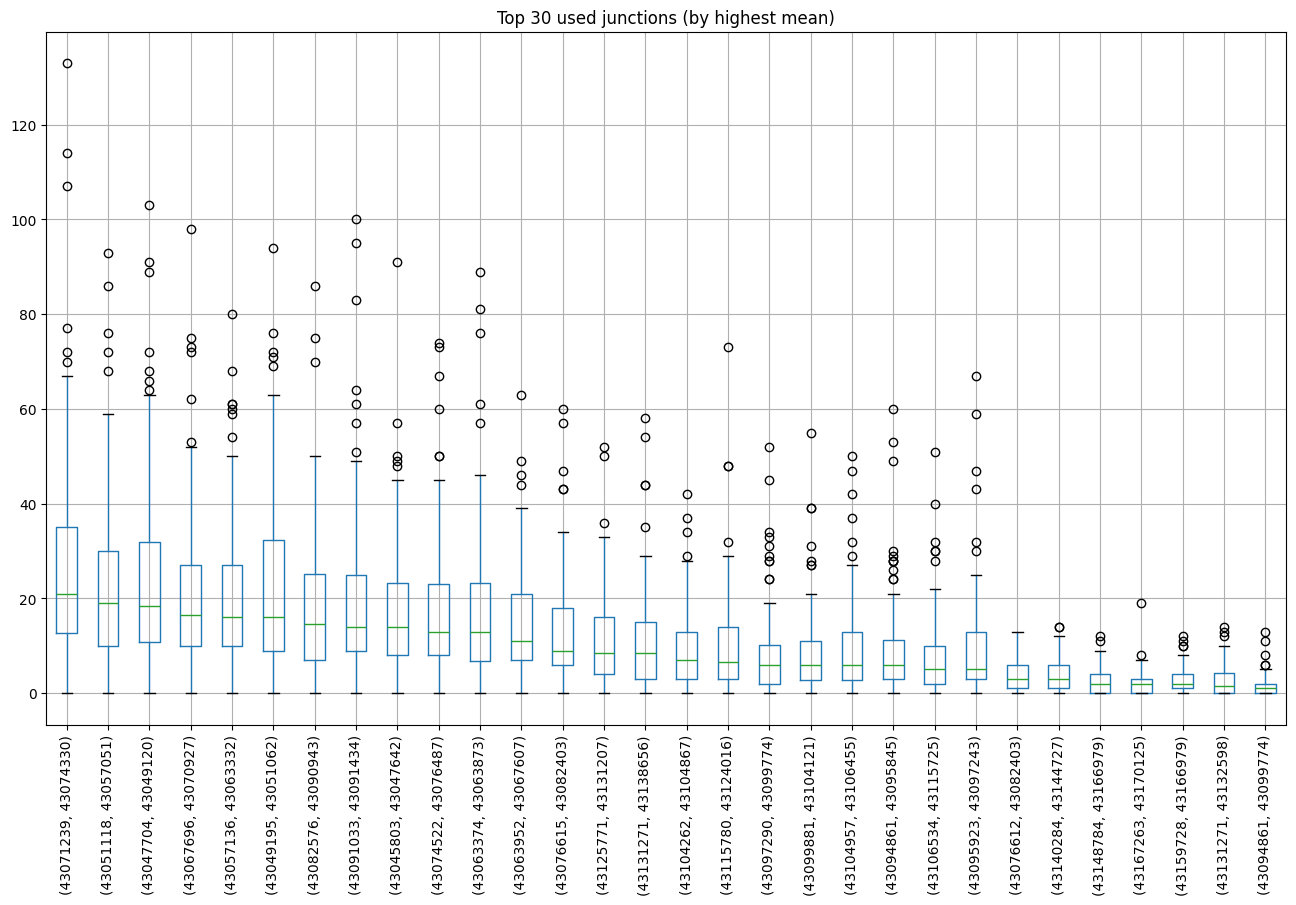

In [4]:
top_n = 30
junctions\
    .reindex(junctions.median().sort_values(ascending=False).index, axis=1)\
    .iloc[:,:top_n]\
    .boxplot(figsize=(16, 9), rot=90)
plt.title(f'Top {top_n} used junctions (by highest mean)')
plt.show()

## Aggregate donor/acceptor probabilities

In [5]:
donor_probs = junctions.T.groupby(level=0).sum().T
acceptor_probs = junctions.T.groupby(level=1).sum().T
# normalize by max usage
# we consider this the "next best" alternative since we can't use actual read
# counts of the genes because those also include exon-only reads that have
# occured
donor_probs = donor_probs.div(donor_probs.max(axis=1), axis=0)
# exact donor base pair is interpreted differently by GDC
donor_probs.columns -= 2
acceptor_probs = acceptor_probs.div(acceptor_probs.max(axis=1), axis=0)

# splice sites can't be donor and acceptor at the same time
faulty_splice_sites = set(donor_probs.columns).intersection(set(acceptor_probs.columns))
if len(faulty_splice_sites) > 0:
    print(f'Invalid data, the following sites are both donor and acceptor: {faulty_splice_sites}')

# merge donor and acceptor
splice_probs = pd.concat([donor_probs, acceptor_probs], axis=1)
splice_probs = splice_probs.reindex(sorted(splice_probs.columns), axis=1)
splice_probs

,43044743,43044774,43045801,43047642,43047702,43049120,43049193,43049781,43049891,43049959,...,43167249,43167261,43167733,43167848,43168169,43168267,43169166,43169756,43170125,43170146
case_id,,,,,,,,,,,,,,,,,,,,,
c1442467-d618-435f-8792-b1a18f696f1a,0.0,0.0,0.307692,0.363636,0.346154,0.409091,0.576923,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.038462,0.000000,0.0,0.0,0.000000,0.181818,0.0
9435447e-d65f-408b-863b-6576b1d652dd,0.0,0.0,0.500000,0.500000,0.222222,0.222222,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
0bf6e772-1aa1-4f54-9a50-c1414e2f22f3,0.0,0.0,0.346154,0.346154,0.730769,0.692308,0.807692,0.0,0.0,0.0,...,0.115385,0.076923,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.500000,0.0
0adf59c6-581a-475d-a2f4-40aa40060b5b,0.0,0.0,0.761905,0.761905,0.666667,0.666667,1.000000,0.0,0.0,0.0,...,0.238095,0.142857,0.0,0.000000,0.000000,0.0,0.0,0.142857,0.476190,0.0
0045349c-69d9-4306-a403-c9c1fa836644,0.0,0.0,0.625000,0.625000,0.958333,0.958333,0.458333,0.0,0.0,0.0,...,0.041667,0.083333,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.166667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97b5f490-1cd9-4833-b903-5f4c6e45670d,0.0,0.0,0.571429,0.571429,1.000000,1.000000,0.500000,0.0,0.0,0.0,...,0.000000,0.035714,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.035714,0.0
991e1427-3c01-423d-abfd-4584302ca72c,0.0,0.0,0.450000,0.450000,1.000000,1.000000,0.650000,0.0,0.0,0.0,...,0.050000,0.100000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.350000,0.0
993103b1-e5a1-4c33-8629-be53ebc41d64,0.0,0.0,0.250000,0.250000,0.375000,0.312500,0.750000,0.0,0.0,0.0,...,0.062500,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.125000,0.0


## Compare predictions against experimental data

In [6]:
def get_probabilities(case_id: str, variants: str = 'wgs_pindel', predictor: SpliceSitePredictor = spliceai):
    result_path = f'{type(predictor).__name__.replace("_", "").lower()}.{variants}.{case_id}.pkl'
    try:
        return pd.read_pickle(find_path(result_path))
    except KeyError:
        pass
    
    ann = Annotator(find_path(study_info.loc[case_id][variants]))
    # predicted splice probability and index alignment
    pps_raw, var_idx = (pd.Series(result) for result in predictor.predict(ann, brca1))
    # normalize by max use analogously to experimental data
    pps_raw /= pps_raw.max()

    # new Series for aligned predictions with max aggregation
    # (we use vanilla dicts for their faster indexing and then convert to series later)
    pps = dict[int, float]()
    for r, indices in enumerate(var_idx):
        for idx in indices:
            pps[idx] = max(pps[idx], pps_raw.loc[r]) if idx in pps else pps_raw.loc[r]
    pps = pd.Series(pps)

    # experimental ("true") splice probabilities
    brca1_range = range(brca1.bp_start, brca1.bp_end + 1)
    tps = splice_probs.loc[case_id].reindex(brca1_range, fill_value=0)

    df = pd.concat([tps, pps], axis=1, keys=['true', 'predicted'])
    # NA predictions mean that the corresponding position was deleted by the variant, i.e. we set them to 0
    df['predicted'] = df['predicted'].fillna(0)

    df = df.loc[brca1_range]
    df.to_pickle(make_path('evaluation', result_path))
    return df

In [12]:
results = pd.Series()
correlations = pd.Series()

for i, case_id in enumerate(study_info.index):
    print(f'CASE {i+1:3d}/{len(study_info)}: {case_id}')
    try:
        df = get_probabilities(case_id, predictor=spliceai)
        results.loc[case_id] = df
        corr = pearsonr(df['true'], df['predicted'])
        correlations.loc[case_id] = corr.statistic
    except Exception as e:
        print('  ERROR')
        print(e)
        print(f'  Skipping case {case_id}')

CASE   1/100: c1442467-d618-435f-8792-b1a18f696f1a


2024-06-29 20:02:32.589416: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-29 20:02:32.589439: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-29 20:02:32.589442: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-29 20:02:32.589469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-29 20:02:32.589486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-06-29 20:02:36.039533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step
CASE   2/100: 9435447e-d65f-408b-863b-6576b1d652dd
1/1 [==============================] - 3s 3s/step
CASE   3/100: 0bf6e772-1aa1-4f54-9a50-c1414e2f22f3
1/1 [==============================] - 1s 1s/step
CASE   4/100: 0adf59c6-581a-475d-a2f4-40aa40060b5b
1/1 [==============================] - 1s 1s/step
CASE   5/100: 0045349c-69d9-4306-a403-c9c1fa836644
1/1 [==============================] - 1s 1s/step
CASE   6/100: 427d0648-3f77-4ffc-b52c-89855426d647
  ERROR
'934b8c4b-7f7a-4001-9f21-c642216b5cbc.wgs.sanger_raw_pindel.raw_somatic_mutation.vcf.gz'
  Skipping case 427d0648-3f77-4ffc-b52c-89855426d647
CASE   7/100: 19015644-9c17-4ae7-a656-0fe8623c04ae
1/1 [==============================] - 1s 1s/step
CASE   8/100: b094e8b2-8ece-4b36-8025-18073a8b873c
1/1 [==============================] - 1s 1s/step
CASE   9/100: 298a1710-deb4-4064-a0f2-da32d43aa217
1/1 [==============================] - 0s 371ms/step
CASE  10/100: 7e1673f8-5758-4963-8804-d

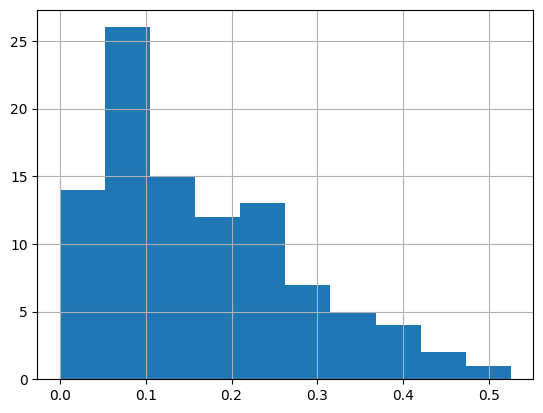

0.16580777638112806


In [13]:
correlations.hist()
plt.show()
print(correlations.mean())

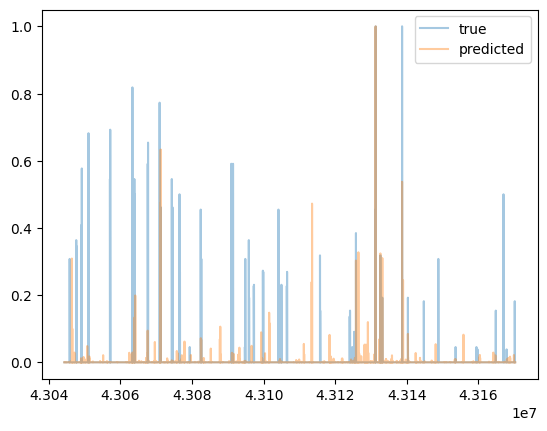

In [14]:
df = results.iloc[0]
df[['true', 'predicted']].plot(alpha=0.4)
plt.show()

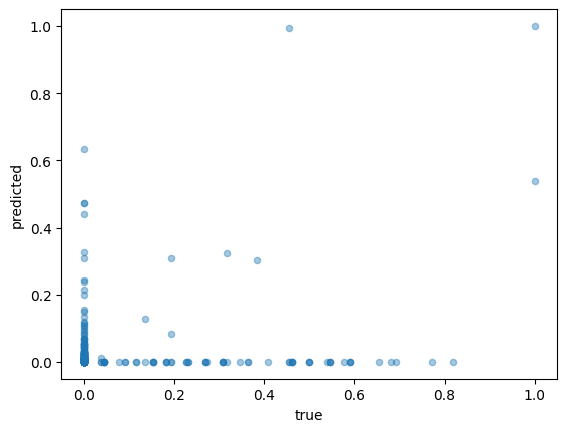

In [15]:
df.plot.scatter('true', 'predicted', alpha=0.4)
plt.show()